# Time Symmetric Integration

Let's look at what happens to our Euler-Cromer integration if we integrate backwards in time.  For our orbit, this would basically mean instead of orbiting counterclockwise it would orbit clockwise.

Start with the Euler-Cromer method:


$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^{n+1}$$

To integrate backwards in time, we change:

* $\tau \rightarrow -\tau$
* $q^{n+1} \rightarrow q^{n-1}$ for any quantity $q$.

This gives us:

$${\bf v}^{n-1} = {\bf v}^n - \tau \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n-1} = {\bf r}^n - \tau \,{\bf v}^{n-1}$$

Rearranging, we have:

$${\bf v}^{n} = {\bf v}^{n-1} + \tau \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n} = {\bf r}^{n-1} +\tau \,{\bf v}^{n-1}$$

This kinda looks like the original Euler-Cromer method, except now the velocity update is implicit (the acceleration is at the "new time") while the position update is explicit.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Velocity Verlet method

The symmetry we see when we look at the time-reversed Euler-Cromer suggests that if we do the two forms in succession, then we will be symmetric in time.  This means doing:

$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^{n+1}$$

$${\bf r}^{n+2} = {\bf r}^{n+1} + \tau \,{\bf v}^{n+1}$$

$${\bf v}^{n+2} = {\bf v}^{n+1} + \tau \,{\bf a}({\bf r}^{n+2})$$

Notice that the middle 2 position updates use the same velocity, so we can combine them as:

$${\bf v}^{n+1} = {\bf v}^n + \tau \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n+2} = {\bf r}^n + 2 \tau \,{\bf v}^{n+1}$$

$${\bf v}^{n+2} = {\bf v}^{n+1} + \tau \,{\bf a}({\bf r}^{n+2})$$

This essentially means that we need to take 2 timesteps that are the same size, one after another.  We can instead take $\tau \rightarrow \tau / 2$ and we get:

$${\bf v}^{n+1/2} = {\bf v}^n + \frac{\tau}{2} \,{\bf a}({\bf r}^{n})$$

$${\bf r}^{n+1} = {\bf r}^n + \tau \,{\bf v}^{n+1/2}$$

$${\bf v}^{n+1} = {\bf v}^{n+1/2} + \frac{\tau}{2} \,{\bf a}({\bf r}^{n+1})$$

This is called the [_velocity Verlet method_](https://en.wikipedia.org/wiki/Verlet_integration#Velocity_Verlet) or the _kick-drift-kick_ method.  It is has time-reversal symmetry and is very popular with N-body integrators.  A related method is [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration).  This is also a type
of [symplectic integration](https://en.wikipedia.org/wiki/Symplectic_integrator) which can be related to Hamilton's equations of motion.

Furthermore, it can be shown that this method is _locally third-order accurate_ and _globally second-order accurate_.

## Time-reversal and energy conservation

Imagine that our method has the property that when we integrate the system, the total energy decreases with time.

That means that if we were to integrate backwards in time, the total energy should increase.

However, if the method is symmetric in time, then the behavior of the energy has to be the same when integrating forward in time and backwards in time.

This means that energy is conserved in a time-symmetric method.

## Application to orbits

Let's apply these new methods to our orbit problems.  To make it interesting, we'll evolve for many periods.

We'll use this module that implements everything for us:
https://github.com/zingale/computational_astrophysics/blob/main/examples/ODEs/orbit.py

In [2]:
import orbit

In [3]:
o = orbit.Orbit(1.0, 0.3)

In [20]:
dt = 0.05
tmax = 50.0 * o.kepler_period()

In [21]:
t_euler, hist_euler = o.int_euler(dt, tmax)
t_ec, hist_ec = o.int_euler_cromer(dt, tmax)
t_rk2, hist_rk2 = o.int_rk2(dt, tmax)
t_rk4, hist_rk4 = o.int_rk4(dt, tmax)
t_vv, hist_vv = o.int_velocity_verlet(dt, tmax)

(-5.0, 2.0)

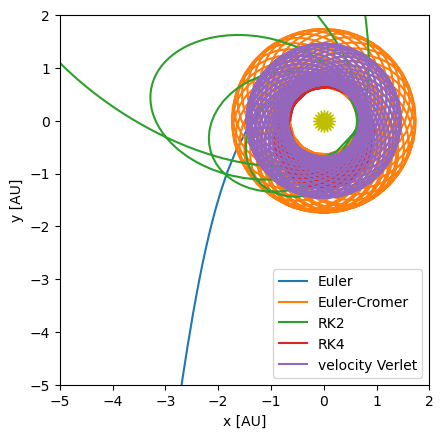

In [22]:
fig = orbit.plot(hist_euler, label="Euler")
orbit.plot(hist_ec, ax=fig.gca(), label="Euler-Cromer")
orbit.plot(hist_rk2, ax=fig.gca(), label="RK2")
orbit.plot(hist_rk4, ax=fig.gca(), label="RK4")
orbit.plot(hist_vv, ax=fig.gca(), label="velocity Verlet")
ax = fig.gca()
ax.legend()
ax.set_ylim(-5, 2)
ax.set_xlim(-5, 2)

Now let's look at the energy

Text(0, 0.5, '$\\mathcal{E}/\\mathcal{E}(t=0)$')

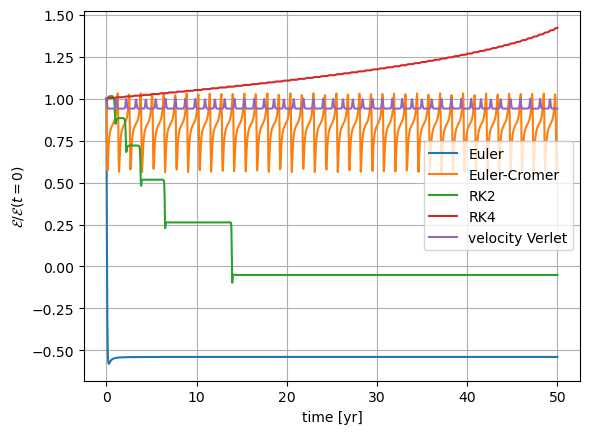

In [24]:
fig, ax = plt.subplots()

E_euler = orbit.energy(hist_euler)
ax.plot(t_euler, E_euler/E_euler[0], label="Euler")

E_ec = orbit.energy(hist_ec)
ax.plot(t_ec, E_ec/E_ec[0], label="Euler-Cromer")

E_rk2 = orbit.energy(hist_rk2)
ax.plot(t_rk2, E_rk2/E_rk2[0], label="RK2")

E_rk4 = orbit.energy(hist_rk4)
ax.plot(t_ec, E_rk4/E_rk4[0], label="RK4")

E_vv = orbit.energy(hist_vv)
ax.plot(t_vv, E_vv/E_vv[0], label="velocity Verlet")

ax.legend()
ax.grid()

ax.set_xlabel("time [yr]")
ax.set_ylabel(r"$\mathcal{E}/\mathcal{E}(t=0)$")

We see that Euler-Cromer and velocity-Verlet both conserve energy over a period, while the other methods have a drift in the total amount of energy over time.

## What about adaptive timestepping?

Unfortunately, velocity-Verlet loses its time-symmetry when you adapt the timestep.

[Hut et al. 1995](https://articles.adsabs.harvard.edu/pdf/1995ApJ...443L..93H) discuss this issue and how to restore time-symmetry into the method.  A nice overview is given in [Boekholt1 et al. 2022](https://arxiv.org/pdf/2212.09745.pdf).


## Higher-order Integrators

The paper [_Construction of higher order symplectic integrators_](https://ui.adsabs.harvard.edu/abs/1990PhLA..150..262Y/abstract) shows how to construct 4th and higher-order
symplectic integrators.

The [REBOUND library](https://rebound.readthedocs.io/en/latest/) provides a wide variety of integrators, symplectic and adaptive, that are used for few-body system
integration.
